In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf
import astropy.constants as const
from astropy import units as u
from scipy import integrate
from scipy.special import wofz
from scipy.integrate import quad
from astropy.modeling.models import Voigt1D, Lorentz1D, Gaussian1D


# Part A:
Compute your own curve-of-growth by plotting the log10(wavelength equivalent width) versus log10(N) for HI Lyman-alpha absorption using the Lorentz function, Gaussian function, and Voigt profile function. Use velocity broadening typical for CNM (T = 80 K) and log10(NHI). You will need to find a range of NHI values so that you can capture and label all portions of the curve-of-growth (optically thin, saturated, and saturated with damping wings).

At what column density values is it appropriate to use the Lorentz and Gaussian functions as an approximation to measure the column density of HI from equivalent width?

In [2]:
# Wavelength range for Lyman-alpha
wavelength = np.arange(1210.67, 1232.67, 0.0002) * u.AA

# Constants
c = 3.0e5 * (u.km/u.s)  # Speed of light in km/s
T = 80 * u.K  # Temperature in Kelvin for CNM
k_B = 1.38e-23 * (u.J/u.K)  # Boltzmann constant in J/K
lambda_alpha = 1215.67 * u.AA # Lyman-alpha wavelength in Angstroms
m_proton = 1.67e-27 *u.kg # Mass of hydrogen atom in kg
b = np.sqrt(2 * k_B * T / m_proton).to(u.km / u.s) # Doppler width
gamma_ul = 4.7*10**8 * (1/u.s) # Damping constant for HI Lyman-alpha A_ul is also defined as the same number (as suggested by textbook)
v_ul = c / lambda_alpha 
v = c * (v_ul - (c/wavelength)) / v_ul
gu = 8
gl = 2
A_ul = 4.6986e+08 * (1/u.s) # Einstein A coefficient for HI Lyman-alpha in s^-1 from NIST


# Line Profiles for Lorentz and Gaussian
Lorentz_Profile = (4 * gamma_ul) / (16 * np.pi**2 * ((c/wavelength) - v_ul)**2 + gamma_ul**2)
Gaussian_Profile = (1/np.sqrt(np.pi)) * (1/v_ul) * (c/b) * np.exp(-(v)**2 / b**2)

# Line Profile for Voigt
a =(gamma_ul*c) / (4*np.pi*v_ul*b) 
u_array = (c/ b) * (1 - ((c/wavelength)/v_ul))
H = np.exp(-u_array**2) + ( a * (1 / (np.sqrt(np.pi) * (u_array**2)) ) )
Voigt_Profile = (1/np.sqrt(np.pi)) * (1/v_ul) * (c/b) * (H) 


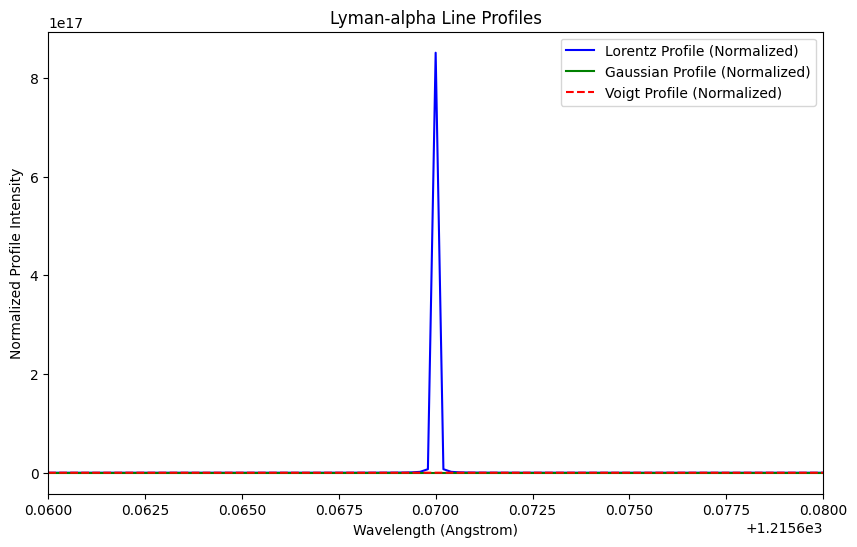

In [3]:
# This is a way to test that the resulting Lyman-alpha profiles look plausible
# They are not on the same scale, but they should have the expected shape once zoomed in
# The scaling is taken care of in the following cell
plt.figure(figsize=(10, 6))
plt.plot(wavelength, Lorentz_Profile, label='Lorentz Profile (Normalized)', color='blue')
plt.plot(wavelength, Gaussian_Profile, label='Gaussian Profile (Normalized)', color='green')
plt.plot(wavelength, Voigt_Profile, label='Voigt Profile (Normalized)', color='red', linestyle='dashed')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Profile Intensity')
plt.xlim(1215.66, 1215.68)
plt.legend()
plt.title('Lyman-alpha Line Profiles')
plt.show()

In [4]:
NHI = np.logspace(12, 22, 100) * (1/u.cm**2)  # HI column density in cm^-2

# Prefactor for calculating tau (optical depth)
prefactor = (gu/gl) * (c**2 / (8 * np.pi * v_ul**2)) *  A_ul 
# Function to calculate equivalent width using trapezoidal integration
def equivalent_width(tau, wavelength):
    # Compute the dimensionless equivalent width and multiply by the wavelength
    return np.trapz((1 - np.exp(-tau)), wavelength)

# Calculate the equivalent width for Voigt profile
EW_V = np.zeros(len(NHI))
for i in range(len(NHI)):
    tau_v = prefactor * NHI[i] * Voigt_Profile
    EW_V[i] = equivalent_width(tau_v, wavelength.value)   

#Calculate the equivalent width for Lorentz profile
EW_L = np.zeros(len(NHI))
for i in range(len(NHI)):
    tau_l = prefactor * NHI[i] * Lorentz_Profile
    EW_L[i] = equivalent_width(tau_l, wavelength.value)

#Calculate the equivalent width for Gaussian profile
EW_G = np.zeros(len(NHI))
for i in range(len(NHI)):
    tau_g = prefactor * NHI[i] * Gaussian_Profile
    EW_G[i] = equivalent_width(tau_g, wavelength.value)



<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_28385/594157129.py:9: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Equivalent Width $[\AA]$')


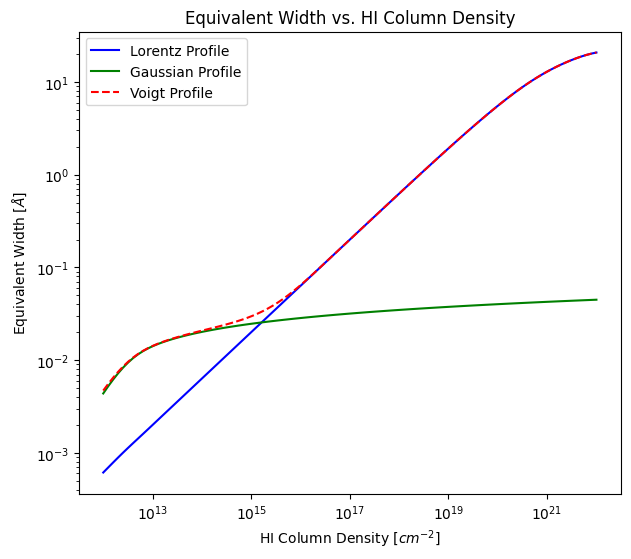

In [5]:
# Plotting the figure for the Equivalent Width vs. HI column density
plot = plt.figure(figsize=(7, 6))
plt.plot(NHI, EW_L, label='Lorentz Profile', color='blue')
plt.plot(NHI, EW_G, label='Gaussian Profile', color='green')
plt.plot(NHI, EW_V, label='Voigt Profile', linestyle = 'dashed', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('HI Column Density $[cm^{-2}]$')
plt.ylabel('Equivalent Width $[\AA]$')
plt.legend()
# plt.xlims = (1e12, 1e22)
plt.title('Equivalent Width vs. HI Column Density')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.savefig('mini_project_images/Equivalent_width_vs_HI.png', dpi=250)
plt.show()

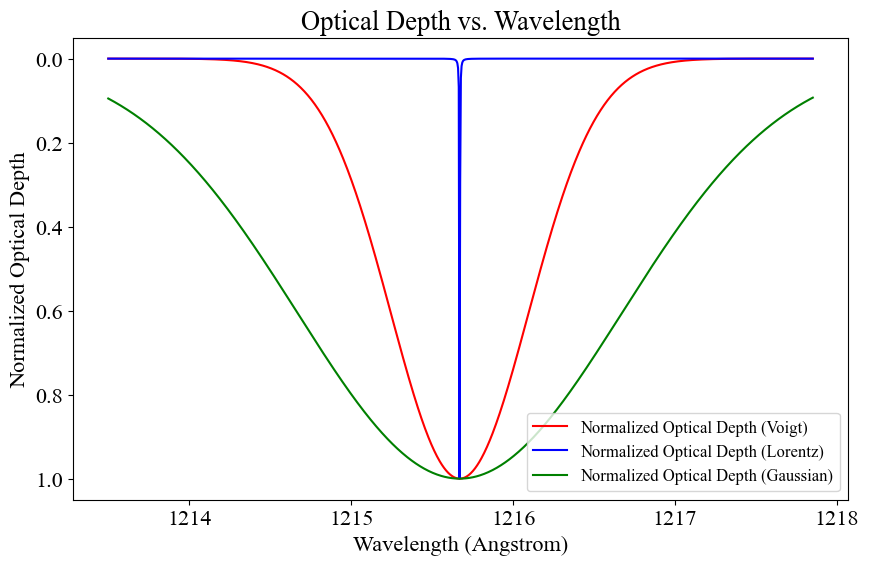

In [6]:
# Constants
lambda_alpha = 1215.67 * u.AA  # Lyman-alpha wavelength
gamma_ul = 4.7*10**-8 * u.AA # 2.458e-08 * u.AA  # Example Lorentz width (FWHM)
b_example = 1.0 * u.AA  # Example Gaussian standard deviation

# Define the profiles using astropy
wavelength = np.linspace(1213.5, 1217.85, 1000) * u.AA
voigt_profile = Voigt1D(x_0=lambda_alpha.value, amplitude_L=1, fwhm_L=gamma_ul.value, fwhm_G=b_example.value)
lorentz_profile = Lorentz1D(x_0=lambda_alpha.value, amplitude=1, fwhm=gamma_ul.value)
gaussian_profile = Gaussian1D(mean=lambda_alpha.value, amplitude=1, stddev=b_example.value)

# Calculate the profiles over the wavelength range
tau_v = voigt_profile(wavelength.value)
tau_l = lorentz_profile(wavelength.value)
tau_g = gaussian_profile(wavelength.value)

# Normalize tau values for comparison
tau_v_normalized = tau_v / np.max(tau_v)
tau_l_normalized = tau_l / np.max(tau_l)
tau_g_normalized = tau_g / np.max(tau_g)

# Plotting the normalized optical depths
plt.figure(figsize=(10, 6))
plt.plot(wavelength, tau_v_normalized, label='Normalized Optical Depth (Voigt)', color='red')
plt.plot(wavelength, tau_l_normalized, label='Normalized Optical Depth (Lorentz)', color='blue')
plt.plot(wavelength, tau_g_normalized, label='Normalized Optical Depth (Gaussian)', color='green')
plt.xscale('linear')  # Use linear scale for x-axis
plt.yscale('linear')  # Use linear scale for y-axis
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Optical Depth')
plt.title('Optical Depth vs. Wavelength')
plt.gca().invert_yaxis()
plt.legend(fontsize=12)
plt.show()


# Part B:
Compute the curve-of-growth the Lyman-beta and Lyman-gamma, and compare it to the curve-of-growth you calculated for Lyman-alpha.

You can use the NIST line database to get fundamental parameters for transition strengths: https://physics.nist.gov/PhysRefData/ASD/lines_form.html

Based on your results, comment on which line features would be more ideal for measuring the abundances of HI at various column densities.

Then make a new plot, picking one line from the above and compute the curve-of-growth using the Voigt profile with velocity broadening typical of the WNM (T =  6000 K). How would the velocity broadening affect measurements of the column density for H?



<>:98: SyntaxWarning: invalid escape sequence '\A'
<>:98: SyntaxWarning: invalid escape sequence '\A'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_28385/3059904883.py:98: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Equivalent Width $[ \AA ]$')


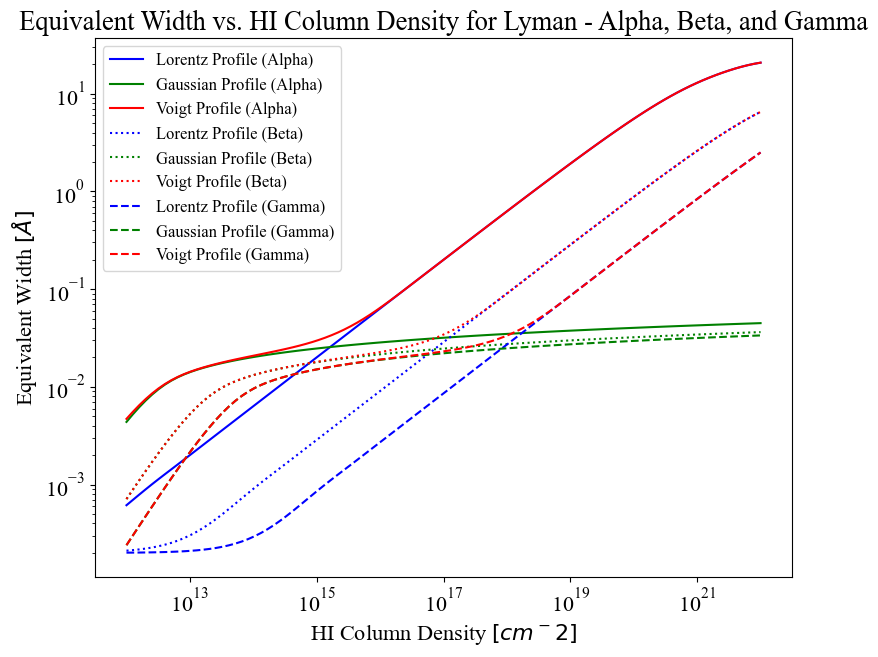

In [7]:
# Define Lyman transitions
transitions = {
    "beta": {
        "wavelength": np.arange(1020, 1030, 0.0002) * u.AA,
        "lambda": 1025.72 * u.AA,  # Lyman-beta wavelength
        "gamma_ul": (5.5751e7 + 4.41e7) / u.s,  # Damping constant for HI Lyman-beta
        "A_ul": 5.5751e+07 / u.s,  # Einstein A coefficient for HI Lyman-beta
        "gu": 18,
        "gl": 2,
    },
    "gamma": {
        "wavelength": np.arange(958, 976, 0.0002) * u.AA,
        "lambda": 972.54 * u.AA,  # Lyman-gamma wavelength
        "gamma_ul": (1.2785e7 + 8.4193e6 + 8.9860e6)  / u.s,  # Damping constant for HI Lyman-gamma
        "A_ul": 1.2785e7 / u.s,  # Einstein A coefficient for HI Lyman-gamma
        "gu": 32,
        "gl": 2,
    }
}

# Prefactor for calculating tau (optical depth)
def calculate_prefactor(v_ul, A_ul, gu, gl):
    return (gu/gl) * (c**2 / (8 * np.pi * v_ul**2)) * A_ul

# Function to calculate the equivalent width using trapezoidal integration
def equivalent_width(tau, wavelength):
    return np.trapz((1 - np.exp(-tau)), wavelength.value)

# Function to compute line profiles and equivalent widths for a given transition
def compute_profiles(transition):
    wavelength = transition["wavelength"]
    lambda_transition = transition["lambda"]
    gamma_ul = transition["gamma_ul"]
    A_ul = transition["A_ul"]
    gu = transition["gu"]
    gl = transition["gl"]

    v_ul = c / lambda_transition
    v = c * (v_ul - (c / wavelength)) / v_ul

    # Line profiles
    Lorentz_Profile = (4 * gamma_ul) / (16 * np.pi**2 * ((c / wavelength) - v_ul)**2 + gamma_ul**2)
    Gaussian_Profile = (1 / np.sqrt(np.pi)) * (1 / v_ul) * (c / b) * np.exp(-(v)**2 / b**2)

    # Voigt profile (simplified approximation)
    a = (gamma_ul * c) / (4 * np.pi * v_ul * b)
    u_array = (c / b) * (1 - (c / wavelength) / v_ul)
    H = np.exp(-u_array**2) + (a / (np.sqrt(np.pi) * (u_array**2 + 1)))
    Voigt_Profile = (1 / np.sqrt(np.pi)) * (1 / v_ul) * (c / b) * H

    prefactor = calculate_prefactor(v_ul, A_ul, gu, gl)

    NHI = np.logspace(12, 22, 100) * (1 / u.cm**2)  # HI column density

    # Calculate the equivalent width for each profile
    EW_V = np.zeros(len(NHI))
    EW_L = np.zeros(len(NHI))
    EW_G = np.zeros(len(NHI))

    for i in range(len(NHI)):
        tau_v = prefactor * NHI[i] * Voigt_Profile
        tau_l = prefactor * NHI[i] * Lorentz_Profile
        tau_g = prefactor * NHI[i] * Gaussian_Profile

        EW_V[i] = equivalent_width(tau_v, wavelength)
        EW_L[i] = equivalent_width(tau_l, wavelength)
        EW_G[i] = equivalent_width(tau_g, wavelength)

    return NHI, EW_V, EW_L, EW_G

# Compute profiles for both Lyman-beta and Lyman-gamma
NHI_beta, EW_V_beta, EW_L_beta, EW_G_beta = compute_profiles(transitions["beta"])
NHI_gamma, EW_V_gamma, EW_L_gamma, EW_G_gamma = compute_profiles(transitions["gamma"])

# Plot the results for Lyman-beta
plt.figure(figsize=(9, 7))

plt.plot(NHI, EW_L, label='Lorentz Profile (Alpha)', color='blue')#, linestyle='dotted')
plt.plot(NHI, EW_G, label='Gaussian Profile (Alpha)', color='green')#, linestyle='dotted')
plt.plot(NHI, EW_V, label='Voigt Profile (Alpha)',  color='red')


plt.plot(NHI_beta, EW_L_beta, label='Lorentz Profile (Beta)', color='blue', linestyle='dotted')
plt.plot(NHI_beta, EW_G_beta, label='Gaussian Profile (Beta)', color='green', linestyle='dotted')
plt.plot(NHI_beta, EW_V_beta, label='Voigt Profile (Beta)', color='red', linestyle='dotted')

# Plot the results for Lyman-gamma

plt.plot(NHI_gamma, EW_L_gamma, label='Lorentz Profile (Gamma)', color='blue', linestyle='--')
plt.plot(NHI_gamma, EW_G_gamma, label='Gaussian Profile (Gamma)', color='green', linestyle='--')
plt.plot(NHI_gamma, EW_V_gamma, label='Voigt Profile (Gamma)', color='red', linestyle='--')


# Formatting the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('HI Column Density $[cm^-2]$')
plt.ylabel('Equivalent Width $[ \AA ]$')
plt.legend()
plt.title('Equivalent Width vs. HI Column Density for Lyman - Alpha, Beta, and Gamma')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.legend(fontsize=12)
plt.savefig('mini_project_images/ALL_Equivalent_width_vs_HI.png', dpi=250)
plt.show()


<>:63: SyntaxWarning: invalid escape sequence '\A'
<>:63: SyntaxWarning: invalid escape sequence '\A'
/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_28385/3328320110.py:63: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Equivalent Width $[ \AA ]$')


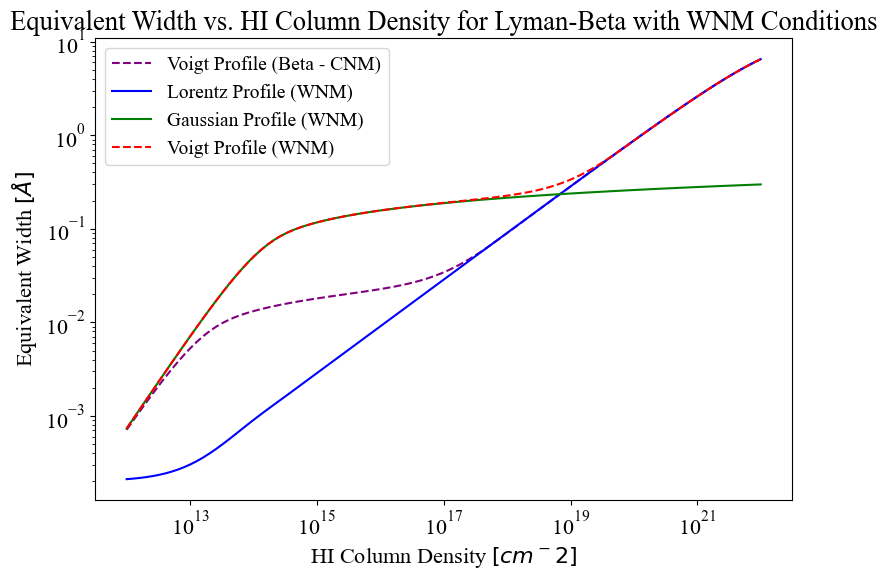

In [8]:
# Update temperature for WNM
T_WNM = 6000 * u.K  # Temperature in Kelvin for WNM

# Recalculate Doppler width for WNM
b_WNM = np.sqrt(2 * k_B * T_WNM / m_proton).to(u.km/u.s)  # Doppler width

# Function to compute line profiles and equivalent widths for a given transition with updated Doppler width
def compute_profiles_WNM(transition, b):
    wavelength = transition["wavelength"]
    lambda_transition = transition["lambda"]
    gamma_ul = transition["gamma_ul"]
    A_ul = transition["A_ul"]
    gu = transition["gu"]
    gl = transition["gl"]

    v_ul = c / lambda_transition
    v = c * (v_ul - (c / wavelength)) / v_ul

    # Line profiles
    Lorentz_Profile = (4 * gamma_ul) / (16 * np.pi**2 * ((c / wavelength) - v_ul)**2 + gamma_ul**2)
    Gaussian_Profile = (1 / np.sqrt(np.pi)) * (1 / v_ul) * (c / b) * np.exp(-(v)**2 / b**2)

    # Voigt profile (simplified approximation)
    a = (gamma_ul * c) / (4 * np.pi * v_ul * b)
    u_array = (c / b) * (1 - (c / wavelength) / v_ul)
    H = np.exp(-u_array**2) + (a / (np.sqrt(np.pi) * (u_array**2 + 1)))
    Voigt_Profile = (1 / np.sqrt(np.pi)) * (1 / v_ul) * (c / b) * H

    prefactor = calculate_prefactor(v_ul, A_ul, gu, gl)

    NHI = np.logspace(12, 22, 100) * (1 / u.cm**2)  # HI column density

    # Calculate the equivalent width for each profile
    EW_V = np.zeros(len(NHI))
    EW_L = np.zeros(len(NHI))
    EW_G = np.zeros(len(NHI))

    for i in range(len(NHI)):
        tau_v = prefactor * NHI[i] * Voigt_Profile
        tau_l = prefactor * NHI[i] * Lorentz_Profile
        tau_g = prefactor * NHI[i] * Gaussian_Profile

        EW_V[i] = equivalent_width(tau_v, wavelength)
        EW_L[i] = equivalent_width(tau_l, wavelength)
        EW_G[i] = equivalent_width(tau_g, wavelength)

    return NHI, EW_V, EW_L, EW_G

# Compute profiles for Lyman-alpha with WNM conditions
NHI_WNM, EW_V_WNM, EW_L_WNM, EW_G_WNM = compute_profiles_WNM(transitions["beta"], b_WNM)

# Plot the results for Lyman-alpha with WNM conditions
plt.figure(figsize=(9, 6))
plt.plot(NHI_beta, EW_V_beta, label='Voigt Profile (Beta - CNM)', linestyle = 'dashed', color='purple')
plt.plot(NHI_WNM, EW_L_WNM, label='Lorentz Profile (WNM)', color='blue')
plt.plot(NHI_WNM, EW_G_WNM, label='Gaussian Profile (WNM)', color='green')
plt.plot(NHI_WNM, EW_V_WNM, label='Voigt Profile (WNM)', linestyle='dashed', color='red')

# Formatting the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('HI Column Density $[cm^-2]$')
plt.ylabel('Equivalent Width $[ \AA ]$')
plt.legend()
plt.title('Equivalent Width vs. HI Column Density for Lyman-Beta with WNM Conditions')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})
plt.legend(fontsize=14)
plt.savefig('mini_project_images/WNM_Equivalent_width_vs_HI.png', dpi=250)
plt.show()


# Part C:
Consider the profiles of lines formed along the line of sight towards a star near the edge of the local bubble. The star is at a distance of 150 pc and the (neutral) hydrogen density along the line of sight to the star is 0.1 cm-3. Assume that the doppler widths of all lines are set by some kind of “turbulent” velocity (i.e., equivalent to a thermal velocity) of 10 km s−1.

Compute the line center optical depth for HI Lyman-alpha absorption and the same for Deuterium (DI) Lyman-alpha absorption, assuming a relative abundance of 1.5 × 10−5.  Comment on which line falls on what portion of the curve of growth

Compute the absorption line profiles using I = I0 e−τ for HI and DI Lyman-alpha as seen in the direction of a background source with normalized intensity I0 = 1 for the given column density and Doppler broadening. Make two plots, one for I(∆V ) with ∆V in km s−1 and another for I(∆λ) with ∆λ in Å. You will have to think about what limits best show your results.

Which line would be more useful to get a column density for Hydrogen?



In [9]:
# Constants
D_H_ratio = 1.5e-5  # Deuterium to hydrogen ratio
T = 80 * u.K  # Temperature for Cold Neutral Medium (CNM)
lambda_alpha_HI = 1215.67 * u.AA  # Lyman-alpha HI wavelength
lambda_alpha_DI = 1215.34 * u.AA  # Lyman-alpha DI wavelength (slightly redshifted) from google
A_ul = 4.6986e+08 * (1/u.s) # Einstein A coefficient for HI Lyman-alpha in s^-1 from NIST
v_ul_HI = c / lambda_alpha_HI  # Frequency of Lyman-alpha transition
v_ul_DI = c / lambda_alpha_DI  # Frequency of Lyman-alpha transition for deuterium
gu = 8  # Upper state degeneracy
gl = 2  # Lower state degeneracy

b = np.sqrt( ((10*(u.km/u.s))**2) * 2 ) 

Nl_HI = (150 * u.pc) * (0.1 * (1/u.cm**3)) # Number density of Lyman-alpha absorbers
Nl_DI = D_H_ratio * Nl_HI # Number density of Lyman-alpha absor

# The optical depth at line center THIS IS AN APPROPRIATE APPROX. BC. a << 1 it is 0.0039 for both 
tau_o_HI = (1 / (4*np.pi)**(3/2)) * (gu / gl) * (c**2 / v_ul_HI**3) * A_ul * (c  / b) * Nl_HI
tau_o_DI = (1 / (4*np.pi)**(3/2)) * (gu / gl) * (c**2 / v_ul_DI**3) * A_ul * (c  / b) * Nl_DI

print('The optical depth at line center for HI is:', '{:.2e}'.format(tau_o_HI.to(u.pc/u.pc).value))
print('The optical depth at line center for DI is:', '{:.2e}'.format(tau_o_DI.to(u.pc/u.pc).value))


The optical depth at line center for HI is: 2.48e+06
The optical depth at line center for DI is: 3.72e+01


In [10]:
I_o = 1  # Intensity of the background source normalized
Intensity = I_o * ( np.exp(-tau_o_HI) + np.exp(-tau_o_DI) )  # Total intensity

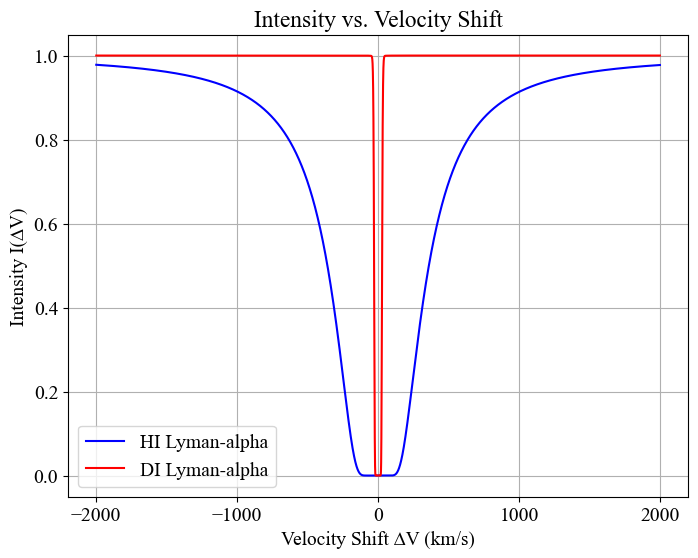

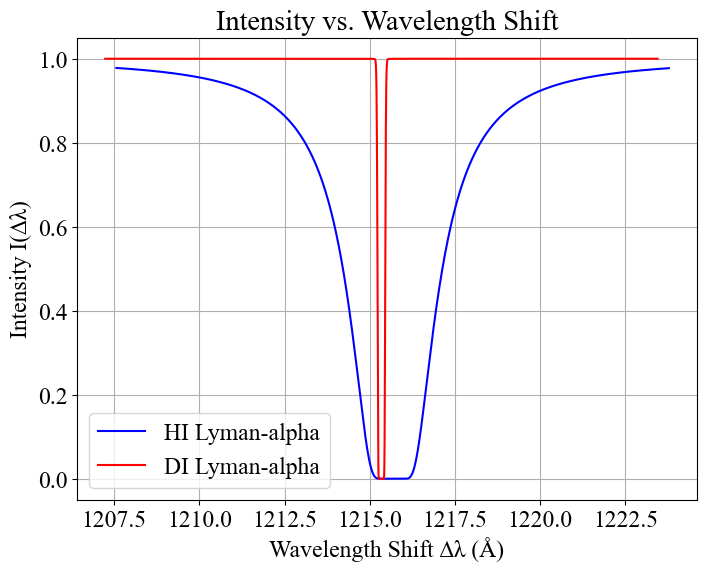

In [11]:
# Define the velocity range for plotting
delta_v = np.linspace(298000, 302000, 10000) * (u.km / u.s)
c = 3.0e5 * (u.km/u.s)  # Speed of light in km/s

# Calculate the corresponding wavelength shifts for HI and DI
delta_lambda_HI = (delta_v / c) * lambda_alpha_HI
delta_lambda_DI = (delta_v / c) * lambda_alpha_DI

gamma_ul = 4.7*10**8 * (1/u.s)

# Line Profile for HI Voigt
a_HI = (gamma_ul * c) / (4 * np.pi * v_ul_HI * b)
u_array_HI = (c / b) * (1 - (c / delta_lambda_HI) / v_ul_HI)
H_HI = np.exp(-u_array_HI**2) + (a_HI / (np.sqrt(np.pi) * (u_array_HI**2 + 1)))
Voigt_Profile_HI = (1 / np.sqrt(np.pi)) * (1 / v_ul_HI) * (c / b) * H_HI
prefactor_HI = (gu / gl) * (c**2 / (8 * np.pi * v_ul_HI**2)) * A_ul

# Line Profile for DI Voigt
a_DI = (gamma_ul * c) / (4 * np.pi * v_ul_DI * b)
u_array_DI = (c / b) * (1 - (c / delta_lambda_DI) / v_ul_DI)
H_DI = np.exp(-u_array_DI**2) + (a_DI / (np.sqrt(np.pi) * (u_array_DI**2 + 1)))
Voigt_Profile_DI = (1 / np.sqrt(np.pi)) * (1 / v_ul_DI) * (c / b) * H_DI
prefactor_DI = (gu / gl) * (c**2 / (8 * np.pi * v_ul_DI**2)) * A_ul

tau_HI = prefactor * Nl_HI * Voigt_Profile_HI
tau_DI = prefactor * Nl_DI * Voigt_Profile_DI


# Calculate the intensity profiles for HI and DI
I_HI = I_o * np.exp(-tau_HI)
I_DI = I_o * np.exp(-tau_DI)

# Plot I(∆V) with ∆V in km/s
plt.figure(figsize=(8, 6))
plt.plot(delta_v - (300000 * u.km/u.s), I_HI, label='HI Lyman-alpha', color='blue')
plt.plot(delta_v - (300000 * u.km/u.s), I_DI, label='DI Lyman-alpha', color='red')
plt.xlabel('Velocity Shift ∆V (km/s)')
plt.ylabel('Intensity I(∆V)')
plt.title('Intensity vs. Velocity Shift')
plt.legend()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 17})
plt.grid(True)
plt.savefig('mini_project_images/Intensity_vs_Velocity.png', dpi=250)
plt.show()

# Plot I(∆λ) with ∆λ in Å
plt.figure(figsize=(8, 6))
plt.plot(delta_lambda_HI, I_HI, label='HI Lyman-alpha', color='blue')
plt.plot(delta_lambda_DI, I_DI, label='DI Lyman-alpha', color='red')
plt.xlabel('Wavelength Shift ∆λ (Å)')
plt.ylabel('Intensity I(∆λ)')
plt.title('Intensity vs. Wavelength Shift')
plt.legend()
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 17})
plt.grid(True)
plt.savefig('mini_project_images/Intensity_vs_Wavelength.png', dpi=250)
plt.show()

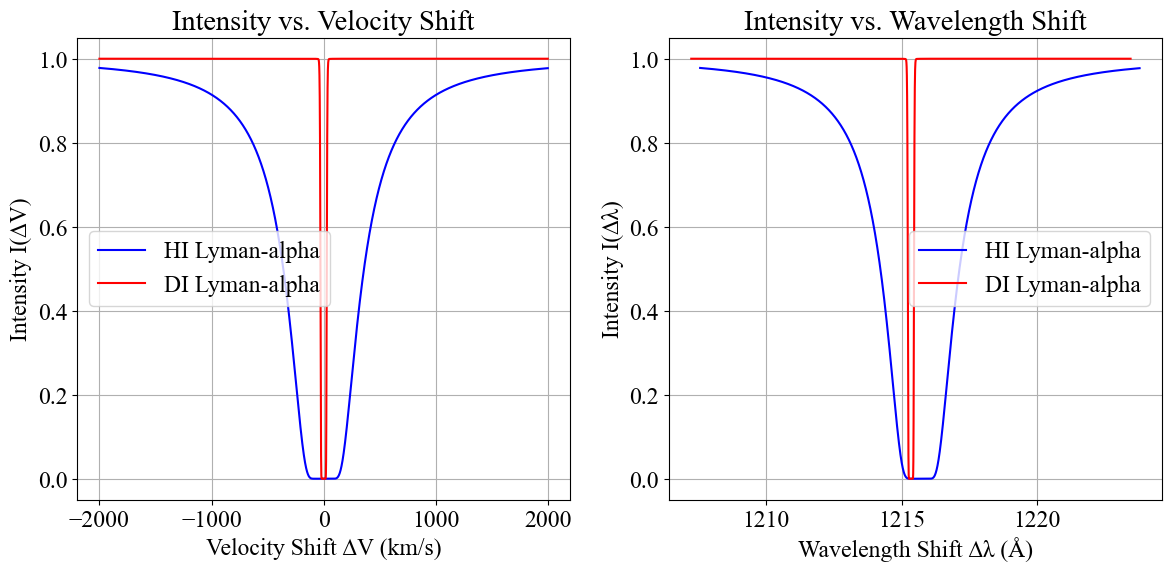

In [12]:

# Define the velocity range for plotting
delta_v = np.linspace(298000, 302000, 10000) * (u.km / u.s)
c = 3.0e5 * (u.km/u.s)  # Speed of light in km/s

# Calculate the corresponding wavelength shifts for HI and DI
delta_lambda_HI = (delta_v / c) * lambda_alpha_HI
delta_lambda_DI = (delta_v / c) * lambda_alpha_DI

gamma_ul = 4.7*10**8 * (1/u.s)

# Line Profile for HI Voigt
a_HI = (gamma_ul * c) / (4 * np.pi * v_ul_HI * b)
u_array_HI = (c / b) * (1 - (c / delta_lambda_HI) / v_ul_HI)
H_HI = np.exp(-u_array_HI**2) + (a_HI / (np.sqrt(np.pi) * (u_array_HI**2 + 1)))
Voigt_Profile_HI = (1 / np.sqrt(np.pi)) * (1 / v_ul_HI) * (c / b) * H_HI
prefactor_HI = (gu / gl) * (c**2 / (8 * np.pi * v_ul_HI**2)) * A_ul

# Line Profile for DI Voigt
a_DI = (gamma_ul * c) / (4 * np.pi * v_ul_DI * b)
u_array_DI = (c / b) * (1 - (c / delta_lambda_DI) / v_ul_DI)
H_DI = np.exp(-u_array_DI**2) + (a_DI / (np.sqrt(np.pi) * (u_array_DI**2 + 1)))
Voigt_Profile_DI = (1 / np.sqrt(np.pi)) * (1 / v_ul_DI) * (c / b) * H_DI
prefactor_DI = (gu / gl) * (c**2 / (8 * np.pi * v_ul_DI**2)) * A_ul

tau_HI = prefactor * Nl_HI * Voigt_Profile_HI
tau_DI = prefactor * Nl_DI * Voigt_Profile_DI


# Calculate the intensity profiles for HI and DI
I_HI = I_o * np.exp(-tau_HI)
I_DI = I_o * np.exp(-tau_DI)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot I(∆V) with ∆V in km/s
ax1.plot(delta_v - (300000 * u.km/u.s), I_HI, label='HI Lyman-alpha', color='blue')
ax1.plot(delta_v - (300000 * u.km/u.s), I_DI, label='DI Lyman-alpha', color='red')
ax1.set_xlabel('Velocity Shift ∆V (km/s)')
ax1.set_ylabel('Intensity I(∆V)')
ax1.set_title('Intensity vs. Velocity Shift')
ax1.legend()
ax1.grid(True)

# Plot I(∆λ) with ∆λ in Å
ax2.plot(delta_lambda_HI, I_HI, label='HI Lyman-alpha', color='blue')
ax2.plot(delta_lambda_DI, I_DI, label='DI Lyman-alpha', color='red')
ax2.set_xlabel('Wavelength Shift ∆λ (Å)')
ax2.set_ylabel('Intensity I(∆λ)')
ax2.set_title('Intensity vs. Wavelength Shift')
ax2.legend()
ax2.grid(True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 17})
plt.savefig('mini_project_images/Intensity_vs_Velocity_and_Wavelength.png', dpi=250)
plt.show()
